In [17]:
# IMPORTS & SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

# Download NLTK data
print("Downloading NLTK data...")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
print("✅ NLTK downloads complete!")

# Check Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Running on: {device}")

✅ NLTK downloads complete!
🔧 Running on: cpu


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# DATA LOADING & PREPROCESSING
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Tweets.csv'

try:
    df = pd.read_csv('/content/drive/MyDrive/Tweets.csv')
    print(f"✅ Dataset loaded! Shape: {df.shape}")
except FileNotFoundError:
    print(f"❌ File not found at {file_path}. Please upload the file or update the path.")
    # Creating dummy data so code doesn't crash if copied directly without file
    df = pd.DataFrame({
        'text': ['flight was great', 'late flight bad', 'ok flight'] * 100,
        'airline_sentiment': ['positive', 'negative', 'neutral'] * 100
    })

Mounted at /content/drive
✅ Dataset loaded! Shape: (14640, 15)


In [19]:
# DATA LOADING & PREPROCESSING
def clean_tweet(tweet):
    if not isinstance(tweet, str): return ""
    tweet = tweet.lower()
    tweet = re.sub(r'@\w+s*', '', tweet)        # Remove mentions
    tweet = re.sub(r'http\S+', '', tweet)       # Remove URLs
    tweet = re.sub(r'[^a-zA-Z\s]', ' ', tweet)  # Keep only letters
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # Remove whitespace
    return tweet

print("Cleaning tweets...")
df['cleaned_text'] = df['text'].apply(clean_tweet)

print(df.head())

# Map labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_label'] = df['airline_sentiment'].map(label_map)

# Remove any NaN labels created by mapping
df = df.dropna(subset=['sentiment_label'])
df['sentiment_label'] = df['sentiment_label'].astype(int)

Cleaning tweets...
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1            

In [20]:
# VOCABULARY & DATASET

X = df['cleaned_text'].values
y = df['sentiment_label'].values

# Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [21]:
# Build Vocab
def build_vocab(texts, max_words=15000): # Increased vocab size slightly
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {word: idx+2 for idx, (word, _) in enumerate(counter.most_common(max_words-2))}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

vocab = build_vocab(X_train)
VOCAB_SIZE = len(vocab)
print(f"✅ Vocabulary size: {VOCAB_SIZE}")

✅ Vocabulary size: 9967


In [22]:
# Convert text to sequences
def text_to_sequence(text, vocab, max_len=30):
    tokens = text.split()
    seq = [vocab.get(token, vocab['<UNK>']) for token in tokens[:max_len]]
    if len(seq) < max_len:
        seq += [vocab['<PAD>']] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

In [23]:
# Create PyTorch Dataset
class TweetDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=30):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        sequence = text_to_sequence(text, self.vocab, self.max_len)
        return {
            'sequence': torch.tensor(sequence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [24]:
# DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(TweetDataset(X_train, y_train, vocab), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TweetDataset(X_val, y_val, vocab), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TweetDataset(X_test, y_test, vocab), batch_size=BATCH_SIZE, shuffle=False)

In [25]:
# BUILD LSTM MODEL

class ImprovedSentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # IMPROVEMENT 1: Bidirectional LSTM
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,  # Enable Bidirectional
            dropout=dropout
        )

        # IMPROVEMENT 2: Increased Dropout
        self.dropout = nn.Dropout(dropout)

        # Input to FC is hidden_dim * 2 because of bidirectional
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        # output: [batch, seq_len, hidden_dim * 2]
        # hidden: [n_layers * 2, batch, hidden_dim]
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Concatenate the final forward and backward hidden states
        # hidden[-2] is the last forward state, hidden[-1] is the last backward state
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        dropped = self.dropout(hidden_cat)
        return self.fc(dropped)

In [26]:
# INSTANTIATE MODEL
# Hyperparameters
EMBED_DIM = 100
HIDDEN_DIM = 64     # Slightly reduced to prevent overfitting given dataset size
OUTPUT_DIM = 3
N_LAYERS = 2
DROPOUT = 0.4       # Increased from 0.3 to 0.5 for regularization

model = ImprovedSentimentLSTM(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
model = model.to(device)

In [27]:
# TRAINING WITH REGULARIZATION
# Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# IMPROVEMENT 3: Weight Decay (L2 Regularization) added to optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# FIX: Removed 'verbose=True' as it is deprecated in newer PyTorch versions
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

In [28]:
# TRAINING LOOP
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in loader:
        seqs, labels = batch['sequence'].to(device), batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, labels)
        loss.backward()

        # IMPROVEMENT 5: Gradient Clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            seqs, labels = batch['sequence'].to(device), batch['label'].to(device)
            outputs = model(seqs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return total_loss / len(loader), 100 * correct / total

# Training Loop
EPOCHS = 30
best_val_acc = 0
patience = 5
patience_counter = 0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'epoch': []
}
print(f"\n🚀 Starting Training (Bidirectional + Dropout {DROPOUT})...")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['epoch'].append(epoch + 1)

    # Step the scheduler based on Validation Accuracy
    scheduler.step(val_acc)

    # Manually print learning rate since verbose is removed
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | LR: {current_lr:.6f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break


🚀 Starting Training (Bidirectional + Dropout 0.4)...
Epoch 1/30 | Train Loss: 0.9197 Acc: 58.39% | Val Loss: 0.7663 Acc: 67.76% | LR: 0.001000
Epoch 2/30 | Train Loss: 0.6848 Acc: 73.10% | Val Loss: 0.7266 Acc: 73.77% | LR: 0.001000
Epoch 3/30 | Train Loss: 0.5591 Acc: 77.89% | Val Loss: 0.7533 Acc: 75.27% | LR: 0.001000
Epoch 4/30 | Train Loss: 0.4678 Acc: 81.95% | Val Loss: 0.7488 Acc: 74.25% | LR: 0.001000
Epoch 5/30 | Train Loss: 0.3917 Acc: 84.90% | Val Loss: 0.8184 Acc: 75.89% | LR: 0.001000
Epoch 6/30 | Train Loss: 0.3256 Acc: 87.73% | Val Loss: 0.8795 Acc: 75.34% | LR: 0.001000
Epoch 7/30 | Train Loss: 0.2606 Acc: 90.35% | Val Loss: 0.9592 Acc: 76.16% | LR: 0.001000
Epoch 8/30 | Train Loss: 0.2228 Acc: 91.63% | Val Loss: 1.1035 Acc: 74.25% | LR: 0.001000
Epoch 9/30 | Train Loss: 0.1855 Acc: 93.16% | Val Loss: 1.2182 Acc: 74.45% | LR: 0.001000
Epoch 10/30 | Train Loss: 0.1699 Acc: 94.23% | Val Loss: 1.2613 Acc: 76.30% | LR: 0.001000
Epoch 11/30 | Train Loss: 0.1430 Acc: 95.21% 

In [29]:
# FINAL TEST EVALUATION

model.load_state_dict(torch.load('best_model.pth', map_location=device))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"\n✅ Final Test Accuracy: {test_acc:.2f}%")


✅ Final Test Accuracy: 78.69%


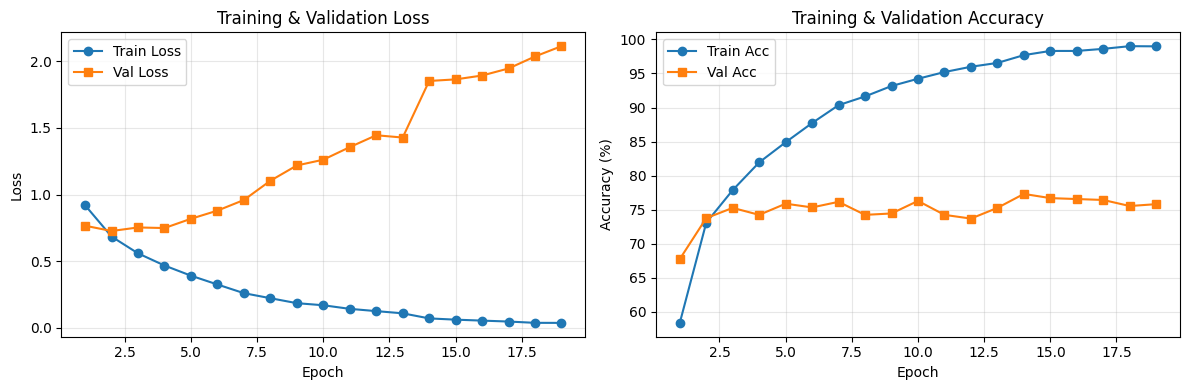


📊 Final Statistics:
Training Accuracy: 98.98%
Validation Accuracy: 75.82%


In [30]:
# VISUALIZE TRAINING

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['epoch'], history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['epoch'], history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['epoch'], history['train_acc'], label='Train Acc', marker='o')
plt.plot(history['epoch'], history['val_acc'], label='Val Acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final stats
print("\n📊 Final Statistics:")
print(f"Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Validation Accuracy: {history['val_acc'][-1]:.2f}%")


🎯 Test Set Performance:
Test Loss: 1.6137
Test Accuracy: 78.69%

📋 Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87       918
     Neutral       0.61      0.64      0.62       310
    Positive       0.75      0.62      0.68       236

    accuracy                           0.79      1464
   macro avg       0.74      0.71      0.72      1464
weighted avg       0.79      0.79      0.79      1464



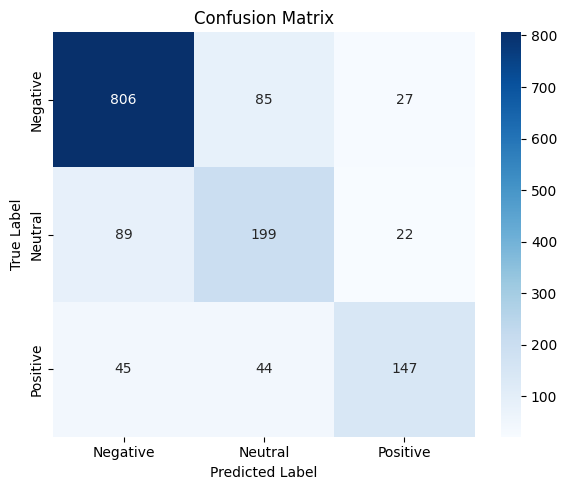

In [31]:
# TEST SET EVALUATION

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"\n🎯 Test Set Performance:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Detailed metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        sequences = batch['sequence'].to(device)
        labels = batch['label'].cpu().numpy()

        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels)

# Classification report
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds,
                            target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()